In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
INPUT_DIR = '/content/drive/MyDrive/atmaCup/#11/dataset_atmaCup11/inputs/'

train = pd.read_csv(INPUT_DIR + 'train.csv')
test = pd.read_csv(INPUT_DIR + 'test.csv')
embeddings = pd.read_csv(INPUT_DIR + 'embeddings.csv')
BERT_materials = pd.read_csv(INPUT_DIR + 'BERT_materials_1d.csv')
BERT_techniques = pd.read_csv(INPUT_DIR + 'BERT_techniques_1d.csv')

In [8]:
data = pd.concat([train, test])

In [9]:
data

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631.0,509357f67692a6a45626,1.0
1,00309fb1ef05416f9c1f,1900.0,7987b47bbe5dc3039179,3.0
2,003a1562e97f79ba96dc,1834.0,ded7c3c9636708e5b14c,3.0
3,004890880e8e7431147b,1743.0,582ac2d7f0cef195b605,2.0
4,00718c32602425f504c1,1885.0,64c907f0c08dce4fb8e8,3.0
...,...,...,...,...
5914,ffbe65ad399b632dcbd0,NaN,NaN,NaN
5915,ffd7b2d646c0320c311a,NaN,NaN,NaN
5916,ffdb93ede17d4501e530,NaN,NaN,NaN
5917,ffe111402004b0ed46b4,NaN,NaN,NaN


In [10]:
data = pd.merge(data, embeddings, on='object_id', how='left')
data = pd.merge(data, BERT_materials, on='object_id', how='left')
data = pd.merge(data, BERT_techniques, on='object_id', how='left')
data

,object_id,sorting_date,art_series_id,target,Unnamed: 0,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,BERT_materials_0,BERT_techniques_0
0,002bff09b09998d0be65,1631.0,509357f67692a6a45626,1.0,0,0.085802,-0.109998,0.562253,0.172158,0.235685,0.643984,-0.297035,-0.077914,0.771065,0.296614,0.229186,0.128695,0.799126,-0.735810,-0.858000,0.074083,-0.284744,-0.284744
1,00309fb1ef05416f9c1f,1900.0,7987b47bbe5dc3039179,3.0,1,-0.377776,2.203817,-0.209372,-1.753532,-1.332891,-1.804229,-1.207214,0.932346,-1.469298,-1.319072,-0.548625,-1.441100,-2.140274,0.312515,0.133071,0.376945,3.332896,3.332896
2,003a1562e97f79ba96dc,1834.0,ded7c3c9636708e5b14c,3.0,2,-0.314644,-0.918230,-1.005571,0.897702,-0.514858,-1.341578,1.768955,-0.834608,-0.764113,0.370925,-0.045328,0.327708,-0.008963,1.051872,1.209304,-0.412155,-0.638979,-0.638979
3,004890880e8e7431147b,1743.0,582ac2d7f0cef195b605,2.0,3,-0.275176,-0.195842,-0.272249,0.571362,-0.034498,-0.306331,1.155633,-0.588240,-0.465584,0.509571,0.049315,0.540030,0.225148,0.733737,0.785568,-0.283782,-2.449573,-2.449574
4,00718c32602425f504c1,1885.0,64c907f0c08dce4fb8e8,3.0,4,-0.267136,-0.408439,-0.572661,0.674455,0.374368,-0.164001,0.796997,-0.680133,0.084354,0.361591,0.450986,0.459829,-0.253252,0.926774,0.382860,-0.806971,-1.513794,-1.513795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9851,ffbe65ad399b632dcbd0,NaN,NaN,NaN,5914,0.770031,-0.234229,0.629901,0.027359,1.060624,1.187675,-0.724965,0.364915,1.133210,0.477653,0.718005,0.196991,-0.067696,-1.222035,-0.838093,0.236990,NaN,NaN
9852,ffd7b2d646c0320c311a,NaN,NaN,NaN,5915,0.070738,-0.355133,0.063620,0.502986,0.131634,0.106500,-0.329814,-0.414935,0.364169,0.587509,0.303484,0.425846,0.117984,0.132747,-0.361223,-0.284736,NaN,NaN
9853,ffdb93ede17d4501e530,NaN,NaN,NaN,5916,0.056158,-0.343251,0.275164,0.291858,0.340172,0.113190,0.414269,-0.350878,0.134322,0.377210,0.177176,0.258334,0.502920,0.207228,0.015563,0.143493,NaN,NaN
9854,ffe111402004b0ed46b4,NaN,NaN,NaN,5917,0.160444,-0.249081,0.607616,0.192381,0.755164,0.857399,-0.397463,-0.133241,0.816307,0.319877,0.293022,0.229697,0.381088,-0.619274,-0.953151,0.206159,NaN,NaN


In [11]:
data.isnull().sum()

object_id               0
sorting_date         5919
art_series_id        5919
target               5919
Unnamed: 0              0
embeddings_0            0
embeddings_1            0
embeddings_2            0
embeddings_3            0
embeddings_4            0
embeddings_5            0
embeddings_6            0
embeddings_7            0
embeddings_8            0
embeddings_9            0
embeddings_10           0
embeddings_11           0
embeddings_12           0
embeddings_13           0
embeddings_14           0
embeddings_15           0
BERT_materials_0     5920
BERT_techniques_0    5920
dtype: int64

In [12]:
data = data.drop('sorting_date', axis=1)
N = len(train)
train = data[:N]
test = data[N:]

In [13]:
print(len(train))
print(len(test))

3937
5919


Stratified Group k-Fold

In [14]:
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

In [15]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [16]:
train.columns

Index(['object_id', 'art_series_id', 'target', 'Unnamed: 0', 'embeddings_0',
       'embeddings_1', 'embeddings_2', 'embeddings_3', 'embeddings_4',
       'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8',
       'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12',
       'embeddings_13', 'embeddings_14', 'embeddings_15', 'BERT_materials_0',
       'BERT_techniques_0'],
      dtype='object')

In [17]:
train_x = train.drop(['object_id', 'art_series_id', 'target', 'Unnamed: 0'], axis=1)
train_y = train.target.values.astype(np.int64)
groups = np.array(train.art_series_id.values)

def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [18]:
distrs = [get_distribution(train_y)]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    dev_y, val_y = train_y[dev_ind], train_y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_y) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3
training set,12.07%,22.76%,38.38%,26.80%
development set - fold 0,12.07%,22.74%,38.37%,26.81%
validation set - fold 0,12.04%,22.81%,38.40%,26.74%
development set - fold 1,12.06%,22.76%,38.38%,26.79%
validation set - fold 1,12.07%,22.74%,38.37%,26.81%
development set - fold 2,12.06%,22.76%,38.38%,26.79%
validation set - fold 2,12.07%,22.74%,38.37%,26.81%
development set - fold 3,12.06%,22.76%,38.38%,26.79%
validation set - fold 3,12.07%,22.74%,38.37%,26.81%
development set - fold 4,12.06%,22.76%,38.38%,26.79%


予想

In [19]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [20]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        pred_i[pred_i < 0.0] = 0.0
        pred_i[pred_i > 3.0] = 3.0
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSE: {:.4f}'.format(score))
    return oof_pred, models

In [21]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 
    
     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,
    
    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,
    
    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 
    
    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 
    
    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 
    
    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,
    
    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,
    
    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [22]:
from sklearn.model_selection import KFold

cv = stratified_group_k_fold(train_x, train_y, groups, k=5)

oof, models = fit_lgbm(train_x.values, train_y, cv, params=params, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.866631
fit fold=0  0.245[s]
Fold 0 RMSE: 0.8666
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	valid_0's rmse: 0.871792
fit fold=1  0.185[s]
Fold 1 RMSE: 0.8718
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.873543
fit fold=2  0.208[s]
Fold 2 RMSE: 0.8735
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's rmse: 0.855354
fit fold=3  0.228[s]
Fold 3 RMSE: 0.8554
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.862377
fit fold=4  0.226[s]
Fold 4 RMSE: 0.8624
--------------------------------------------------
FINISHED | Whole RMSE: 0.8660


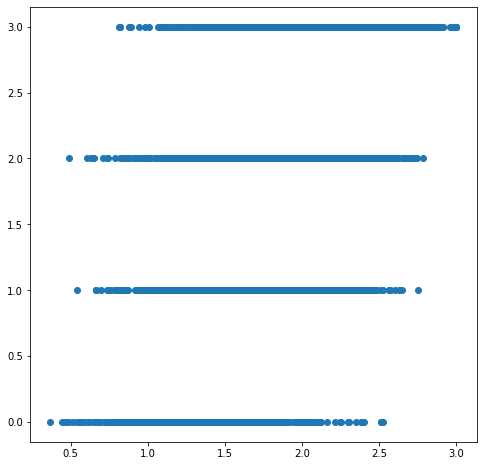

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oof, train_y)

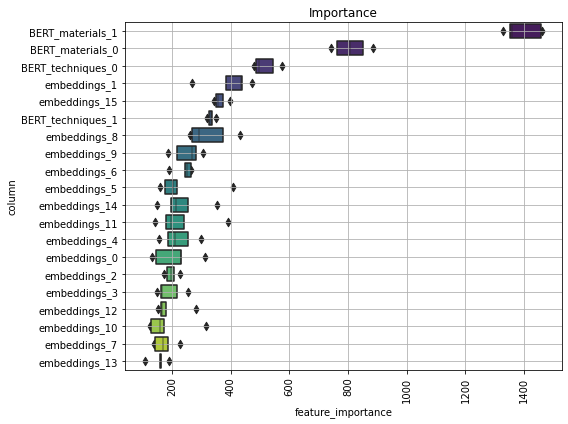

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_x)

In [ ]:
pred = np.array([model.predict(test.drop(['object_id','art_series_id','target','Unnamed: 0'],axis=1).values) for model in models])
pred = np.mean(pred, axis=0)

In [ ]:
pred[pred < 0.0] = 0.0
pred[pred > 3.0] = 3.0

In [ ]:
pred = pred.reshape(-1,)

In [ ]:
pred.shape

(5919,)

In [ ]:
OUTPUT_DIR =  '/content/drive/MyDrive/atmaCup/#11'

pred = pred.reshape(-1,1)
sub_df = pd.DataFrame(data=pred, index=list(range(len(pred))), columns=['target'])
os.makedirs(os.path.join(OUTPUT_DIR, 'outputs'), exist_ok=True)
sub_df.to_csv(os.path.join(os.path.join(OUTPUT_DIR, 'outputs'), 'submission20210710_2210.csv'), index=False)